# Visualizing the Embedding space with PCA and BERT

In this notebook, we will use our embedded fasta files to generate PCA visualizations of the embedding space for subcellular location.

In [4]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

First, we will load our npz files using numpy as well as the label files generated in `generate_deeploc_data.ipynb`. Next, we will iterate through the train, valid, and test arrays to generate a dataframe with the embedded features for each sequence

In [123]:
lookup_d = {}
seq_list = []
count = 0

id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}

# generate lookup dictionary for labels from original fasta file
for record in SeqIO.parse("deeploc_data_cleaned_6000.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    count += 1
    desc_split = description.split(" ")
    if len(desc_split) == 3:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        lookup_d[ID] = label
    
    else:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        lookup_d[ID] = label

# load data from npz files
train_arrays = np.load('../data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('../data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('../data/output_deeploc_test.npz', allow_pickle=True)


# generate dataframes and associated labels from lookup
def gen_df(df, label_list, arrays):
    l = list(arrays.keys())
    labels = []
    for a in l:
        d = arrays[a].item()['avg']
        append_df = pd.DataFrame(d)
        labels.append(lookup_d[a])
        df = df.append(append_df.transpose(), ignore_index=True)
    return df, labels

train_df, train_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_labels = gen_df(pd.DataFrame(), [], test_arrays)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(9974, 768)
(1109, 768)
(2773, 768)


In [126]:
deeploc_df = train_df.append(valid_df, ignore_index=True).append(test_df, ignore_index=True)
labels = train_labels + valid_labels + test_labels

Using PCA, we can reduce the overall dimensionality of our data to visualize it in two or 3 dimensions.

In [127]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(deeploc_df)
print(sum(pca.explained_variance_ratio_))

0.2792523467750515


In [128]:
explained_variance = []
n_components = [1, 2, 3, 5, 10, 50, 100, 250, 500, 750]
for n in n_components:
    pca_t = PCA(n_components=n)
    principalComponents_t = pca_t.fit_transform(deeploc_df)
    explained_variance.append(sum(pca_t.explained_variance_ratio_))

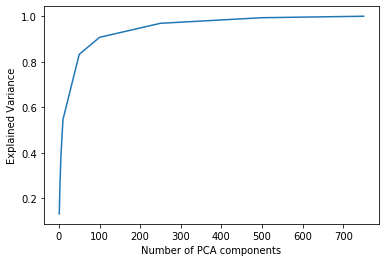

In [129]:
import matplotlib.pyplot as plt
plt.plot(n_components, explained_variance )
plt.ylabel('Explained Variance')
plt.xlabel('Number of PCA components')
plt.show()

We see that the variance explained in 3 dimensions is only around 28 percent, whereas greater than 100 components explains around 95% of the data. For visualization purposes, we can see how our data looks in 2 and 3 dimensions.

In [130]:
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])
principal_df['label'] = labels
principal_df

,pc1,pc2,pc3,label
0,-0.121326,-4.635504,-1.145841,Cytoplasm
1,-2.249382,-2.719347,-1.381751,Cytoplasm
2,-2.542184,2.490768,3.434970,Cytoplasm
3,-0.783468,-2.249001,-0.489159,Mitochondrion
4,-1.089031,0.618051,3.307563,Cell.membrane
...,...,...,...,...
13851,-3.011951,-1.045385,-0.780423,Mitochondrion
13852,-2.087074,4.107835,-3.085178,Cell.membrane
13853,1.000565,0.151733,0.968621,Nucleus
13854,3.296985,-1.209185,0.519692,Nucleus


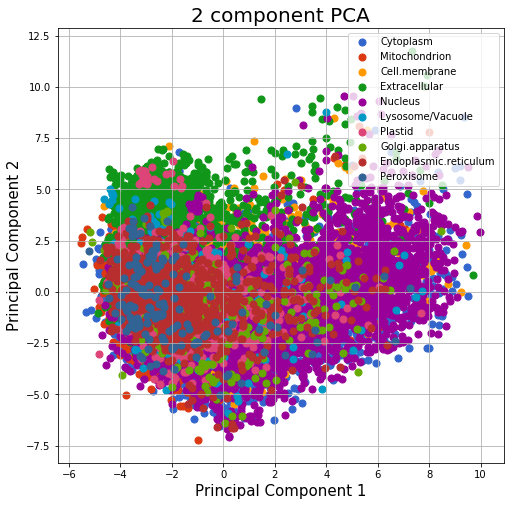

In [131]:
import matplotlib.pyplot as plt
import plotly.express as px
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(principal_df['label'].unique())
colors =px.colors.qualitative.G10
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['label'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'pc1']
               , principal_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [132]:
import plotly.express as px
plt.figure(figsize=(25, 25))
fig = px.scatter(principal_df, x='pc1', y='pc2',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

<Figure size 1800x1800 with 0 Axes>

In [133]:
import plotly.express as px
fig = px.scatter_3d(principal_df, x='pc1', y='pc2', z='pc3',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [135]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels
print(len(train_valid_df))
print(len(train_valid_labels))

11083
11083


In [138]:
clf = LogisticRegression()
clf.fit(train_valid_df, train_valid_labels)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
clf.score(train_valid_df, train_valid_labels)

0.7951818099792475

In [140]:
clf.score(test_df, test_labels)

0.6628200504868373